# Evolution & phylogenetic reconstruction

*Written by Bastiaan van der Weij and Dieuwke Hupkes.\
Updated by Bas Cornelissen, Peter Dekker and Marianne de Heer Kloots.*

In this computer lab you will experiment with simulated evolution and phylogenetic reconstruction: the reconstruction of the evolutionary history of species, simulated genes, and even language and music.

The lab contains <font color="orange"><b>Code</b></font> questions, where you need to enter some code to compute or simulate something yourself, and <font color="green"><b>Think</b></font> questions, which check your understanding of what is happening.

Some notes on using this notebook: 

- You should run all the code cells in this notebook, either by clicking the 'play button' that appears once you hover over them (in Google Colab) or by pressing Shift+Enter from inside each cell. Make sure you don't miss any! Once a cell has completed running, a number will appear between the [square brackets] to the left of the cell.
- You may run a cell multiple times (for example to check how the output changes). 
- In principle, you could also run a previous cell again after you've run the cells below it. However, this might be a bad idea, and cause you trouble once you try to run new code further down the line again. If this happens and you run into strange errors, you can always try to restart the notebook (Ctrl+M or _Runtime > Restart runtime_ in the menu) and carefully run each cell from top to bottom again.
- To see an overview of the entire computer lab, and easily navigate between sections, open the _Table of contents_ tab to the left (first icon in the navigation bar).

## 0. Getting started with R
We assume you have some basic understanding of
programming and R. You will not have to write a lot of code yourself,
but you should be able to read and run the scripts that we provide you
with. If you have never seen any R code before, it might be useful for
you to work through a tutorial, such as the first three pages of [this
tutorial by Bart de
Boer](http://projects.illc.uva.nl/LaCo/CLAS/clc13/assignments/deboer13rtutorial.pdf).
Of course, you can always ask us for help if you are stuck on a
particular piece of code!

### Installing packages
This cell installs and loads some external packages that we will need throughout the computer lab. It may take a few minutes to run!

In [ ]:
# list of packages to install
to_install <- c("stringr", "ape", "phangorn", "plotly")

# create writable library for the packages
if (!file.exists("library")){
    dir.create("library")
}

# install packages to the library
if (!all(file.exists(paste('library/', to_install, sep="")))){
    to_install <- to_install[!file.exists(paste('library/', to_install, sep=""))]
    install.packages(to_install, "library/")
}

# tell R where the library is
.libPaths('library/')

# load packages from the library
library(stringr)
library(ape)
library(phangorn)
library(plotly)

### Downloading dataset
This cell downloads a dataset that we have preprocessed for you, to use in [section 5](#5.-Phylogenetic-reconstruction-of-languages) of this computer lab.

In [ ]:
if (!file.exists("data")){
    dir.create("data")
}
if (!file.exists("data/language_data.Rdata")){
    download.file("https://github.com/clclab/elm-labs/raw/main/book/language_data.Rdata", 
              "data/language_data.Rdata", mode="wb")
}

### Auxiliary functions
The code below defines some of our own functions and variables that we will use throughout this computer lab. Run the cell so they are loaded; afterwards, you can collapse the cell and directly [skip to the first section](#1.-Simulated-evolution) for now. But if you want to examine these functions more closely later on, you can go back to this cell (and expand it) to do so.

In [3]:
# alphabet
alphabet <- c("A","G","U","C")

# target matrices if fixed target is used
target_R <- matrix(c(1,0,0,0,1,0,0,0,1),3,3)
target_S <- matrix(c(1,0,0,0,1,0,0,0,1),3,3)
target_agent = list(R=target_R, S=target_S)

CAC_count <- function(population) {
  # fitness function based on number of
  # occurences of substring CAC
  fitness <- rep(0,population_size)
  for (i in 1:population_size) {
    population_member <- paste(population[i,], collapse='')
    fitness[i] <- str_count(population_member, "CAC")
  }
  return(fitness)
}

# Mutation function

mutation_matrix <- matrix(rep(1/3,16),4,4)
diag(mutation_matrix) <- 0

mutate_population_fast <- function(population) {
  # choose number of elements to change
  N_change <- rbinom(1, genome_size*population_size, prob=mu)
  
  # generate indices of elements to change
  indices <- sample(genome_size*population_size, size=N_change)
  
  # change elements
  for (index in indices) {
    row <- ceiling(index/genome_size)
    column <- index %% genome_size + 1
    distr <- mutation_matrix[match(population[row, column], alphabet),]
    population[row, column] <- sample(alphabet, size=1, prob=distr)
  }
  
  return(population)
}

population <- c(rep(1,10))
for (i in 1:10) {
  population[i] <- paste(sample(c("A","G","C","U"),size=18, replace=TRUE), collapse="")
}


## Auxiliary functions for phylogenetic trees

compute_diversity <- function(population) {
  return(nrow(unique(population)))
}

# construct a tree from a population using a parent matrix
reconstruct_tree <- function(parent_matrix) {
  D <- nrow(parent_matrix)    # maximum depth tree
  N <- ncol(parent_matrix)    # population size
  N_cur <- N                  # cur population size
  cur_depth <- 0              # cur depth tree
  
  children_indices <- seq(1,N,1)
  children <- as.character(seq(1,N,1))
  
  while (N_cur > 1 && cur_depth < D) {
    # while (cur_depth < D) {
    # create an empty list of population size to group children
    # under the right parent (index)
    parents <- vector("list",N)
    has_children <- rep(0,N)
    
    # loop over the children by looping over their indices
    child_index <- 1
    for (child in children_indices) {
      parent <- parent_matrix[D-cur_depth,child]  # find index of parent in prev generation
      child <- children[[child_index]]            # get child from array
      cur_children_parent <- parents[[parent]]    # check if parent already is assigned children
      cur_number_children <- has_children[parent] # check number of children for parent
      
      # assign child to parent
      if (cur_number_children == 0 && cur_depth > 0) {        # first child, child is already a tree
        parents[[parent]] <- children[[child_index]]
      } else if (cur_number_children == 0) {                  # first child, child is leaf node
        parents[[parent]] <- list(children[child_index])
      } else if (cur_depth == 0) {                            # not first child, child is leaf node
        parents[[parent]][[cur_number_children+1]] <- child
      } else if (cur_number_children == 1) {                  # second child, child is already a tree, children is not yet a list
        parents[[parent]] <- list(cur_children_parent, child)
      } else {                                                # third or more child
        parents[[parent]][[cur_number_children+1]] <- child
      }
      
      has_children[parent] <- has_children[parent] + 1        # increase children for parent
      
      child_index <- child_index + 1
    }
    nulls <- sapply(parents, FUN=is.null)       # check which prev population members didn't have children
    children_indices <- seq(1,N,1)[!nulls]   # get the indices of the parents, set children to them
    children <- parents[!nulls]
    N_cur <- length(children_indices)
    cur_depth <- cur_depth + 1
  }
  if (N_cur > 1) {
    print("Disconnected tree")
  } else {
    return(children)
  }
}

# print a nested_list in newick-format
print_tree <- function(nested_list) {
  str_repr <- paste(capture.output(dput(nested_list)),collapse='')
  str_repr <- gsub("[\r\n]","",str_repr)
  str_repr <- gsub('\"',"",str_repr)
  str_repr <- gsub('list',"",str_repr)
  str_repr <- paste(str_repr, ";")
  str_repr <- gsub(' ',"",str_repr)
  return(str_repr)
}

# plot tree
plot_tree <- function(tree) {
  cat(print_tree(tree), file="tree.nwk", sep="\n")
  tree_sim <- read.tree("tree.nwk")
  plot(tree_sim, cex=0.45)
}

# print connections in the parent matrix
print_parent_matrix <- function(parent_matrix) {
  height <- nrow(parent_matrix); width <- ncol(parent_matrix)
  N <- (height)*width
  x_from <- rep(seq(1,width,1),times=height)
  y_from <- rep(seq(1,height,1),each=width)
  y_to <- rep(seq(2,height+1,1),each=width)
  x_to <- rep(0,N)
  counter <- 1;
  for (population in height:1) {
    for (individual in 1:width) {
      x_to[counter] <- parent_matrix[population,individual] 
      counter <- counter+1
    }
  }
  par(mfrow=c(1,1))
  plot(width, height+2, xlim=c(1,width), ylim=c(0,height+2), type="n", yaxt="n", xaxt="n", 
       xlab="population member", ylab="generation")
  axis(1, at=c(1:10))
  segments(x_from, y_from, x_to, y_to)
  points(c(x_from, x_to), c(y_from, y_to), pch=19)
}

# compute distance matrix
compute_distance_matrix <- function(population) {
  N <- nrow(population)
  dm <- matrix(rep(0,N*N),N,N)
  for (i in 1:(N-1)) {
    for (j in (i+1):N) {
      agent1 <- population[i,]
      agent2 <- population[j,]
      dm[j,i] <- compute_distance(agent1, agent2)
    }
  }
  colnames(dm) <- as.character(seq(1,N))
  rownames(dm) <- as.character(seq(1,N))
  dm <- as.dist(dm,diag=FALSE,upper=FALSE)
  return(dm)
}

# compute normalised hamming distance between two strings
compute_distance <- function(agent1, agent2) {
  l <- length(agent1)
  helper <- rep(0,l)
  d <- length(helper[!agent1 == agent2])/l
  return(d)
}

## 1. Simulated evolution

The goals of this section are:

-   to better understand the concepts of genotype, genotype space,
    fitness, fitness landscape, selection, mutation, selection-mutation
    balance, frequency dependent selection;

-   to see how these concepts can be formalised in a computer program;

-   to appreciate both the power and the limits of natural selection.


### 1.1 Creating a population
In the first part of this computer lab, we will use R to simulate the evolution of (DNA) strings under a particular fitness function. We will represent DNA strings (the genotype) as a sequence of the letters ‘A’, ‘G’, ‘C’ and ‘U’. In R, you can generate a random sequence of 10 of these letters using the following command:

```r
sample(c('A','G','C','U'), size=10, replace=TRUE)
```

To store the output in a variable (for instance x), you type:

```r
x <- sample(c('A','G','C','U'), size=10, replace=TRUE)
```
You can then view the contents of a particular variable by printing it. 

Let’s try this, by running the cell below:

In [4]:
x <- sample(c('A','G','C','U'), size=10, replace=TRUE)
print(x)

 [1] "C" "C" "A" "C" "C" "U" "G" "U" "G" "U"


#### **Exercise 1: Creating a genotype**
- First, use the cell above to generate a few random sequences of length 10 containing the characters 'A', 'G', 'C' and 'U', and confirm that it does what we want it to do.
- <font color="orange"><b>Code:</b></font> In the code cell below, generate a random sequence of length 50 containing the characters 'A', 'G', 'C' and 'U'.
- <font color="green"><b>Think:</b></font> The set of all possible sequences is called the _genotype space_. How big is this space? I.e., how many genotype strings are possible with our representation?

(Note that R ignores everything that follows the character #. In programming terms, these texts are called _comments_.) 

In [4]:
 ### YOUR CODE HERE ###
 

> [ Your answer here ]

#### **Exercise 2: Creating the population**
Now, let’s create a _population_ of DNA strings. To do this, we will make 100 genotype strings. We will store our population in a matrix (the _population matrix_), where each member of our population is represented as a row of the matrix. 

The command `matrix(x, height, width)` command transforms a vector `x` into a matrix with height `height` and width `width`.

Let’s start with creating a matrix filled with zero’s that we can later fill:

In [5]:
population <- matrix(rep(0, 100), 100, 50)

- <font color="green"><b>Think:</b></font> So what do we find in column 30 of our population matrix, and what does this number mean?

> [ Your answer here ]

`population[,j]` accesses the `j`th column of the matrix `population`. 

`population[i,]` accesses the `i`th _row_ of the matrix `population`, which in our case corresponds with the `i`th member of our population.

We fill our matrix by generating 100 population members in a for-loop and filling the matrix with them:

In [6]:
population_size <- 100
for (i in 1:population_size) {
    population[i,] <- sample(c('A','G','C','U'),
      size=50, replace=TRUE)
}

### 1.2 Defining a fitness function
Now we need to define a fitness function that computes the fitness of
the individual members of our population. Imagine, for instance, that
the string 'CAC' codes for some very useful aminoacid. The more CAC's in
the genome, the higher the expected number of offspring. In our
simulation of evolution, let's define the fitness as the number of times
the substring 'CAC' appears in the genotype string (without overlap, so
the string 'CACAC' contains *one* copy of 'CAC').

To keep track of the fitness of *all* members in our population (which
are represented as rows in the population matrix), we create a *vector*
where each element of the vector represents the fitness value for one
member of the population.

#### **Exercise 3: Compute each member's fitness value**

We generate an empty vector to store the fitness values, and call it `fitness`:

In [7]:
fitness <- rep(0, population_size)

Now, we use a for-loop to fill the vector (created by the code above) with the fitness values:

In [8]:
# loop over population size
for (i in 1:population_size) {      
  # generate string representation
  member <- paste(population[i,], collapse='') 
  
  # compute fitness member   
  fitness_member <- str_count(member, "CAC")   
  
  # store in fitness vector
  fitness[i] <- fitness_member
}

- <font color="green"><b>Think:</b></font> What is the highest possible fitness a member of this population can have?
- <font color="orange"><b>Code:</b></font> Compute the mean fitness of your population, by using `mean(fitness)` in the code cell below and storing the result to a new variable `av_fitness`. What is the average fitness of your population?

> [ Your answer here ]

In [9]:
### YOUR CODE HERE ###


### 1.3 Implementing selection
Now we will generate the next generation. We assume that each member of the next generation inherits the genome of one of the members of the previous generation. The probability of inheriting each genome is proportional to the genome’s fitness: a child is most likely to inherit the genome of the fittest member of the previous population. This simulates selection.

#### **Exercise 4: A new population**

We generate 100 new children, using the built-in function `sample` (the same one we used before). We first draw 100 random numbers between 1 and 100 (repetitions possible), and store them in the variable `indices`. The likelihood of being drawn depends on a member's fitness: if population member 2 has a very high fitness, it will have a very high chance of being drawn. Then we use the drawn numbers to create a new population of the members corresponding to the numbers.

In [9]:
indices <- sample(100, size=100, replace=TRUE, 
                prob=fitness/sum(fitness))
new_population <- population[indices,]

- <font color="green"><b>Think:</b></font> If one population member has fitness 10 and all the other population members have fitness 1, what is the probability that a child will inherit its genome from this one population member? What do you expect to happen with the population?

> [ Your answer here ]

#### **Exercise 5: Population fitness over generations**

To simulate the evolution of the population, we want to repeat this process several times and plot the average fitness over time. The cell below defines the functions `generate_population` and `simulate_evolution`, which allow us to do this easily.

In [10]:
# Function to generate new population
generate_population <-  function(population_size, genome_size) {
    # generate initial population with random strings
    population <- matrix(rep(0,population_size*genome_size), population_size, genome_size)
    for (i in 1:population_size) {
        new_member <- sample(c('A','G','C','U'), size=genome_size, replace=TRUE)
        population[i,] <- new_member
    }

    return(population)
}

# Function to simulate evolution
simulate_evolution <- function(population) {

    # compute fitness
    fitness <- CAC_count(population)

    av_fitness <- rep(0, simulation_length)
    av_fitness[1] <- mean(fitness)

    # simulate evolution
    for (j in 2:simulation_length) {

        # generate children by sampling from the population according to fitness
        population_children <- population[sample(population_size, size=population_size, replace=TRUE, prob=fitness/sum(fitness)),]

        # mutate children
        population <- mutate_population_fast(population_children)

        # recompute fitness
        fitness <- CAC_count(population)

        # add to list with average fitness
        av_fitness[j] <- mean(fitness)
    }

    # plot average fitness
    ymax <- av_fitness[simulation_length]+2
    generation <- seq(1,simulation_length,1)
    par(mfrow=c(1,1))
    plot(generation, av_fitness, type="l", ann=FALSE, ylim=c(0,ymax))
    title(main="Average population fitness", xlab="Generation", ylab="Fitness")

    return(population)
}

Now, we can run a simulation with our desired settings. Try it out with the cell below (you can ignore the parameter `mu` for now, we will get to it very soon).

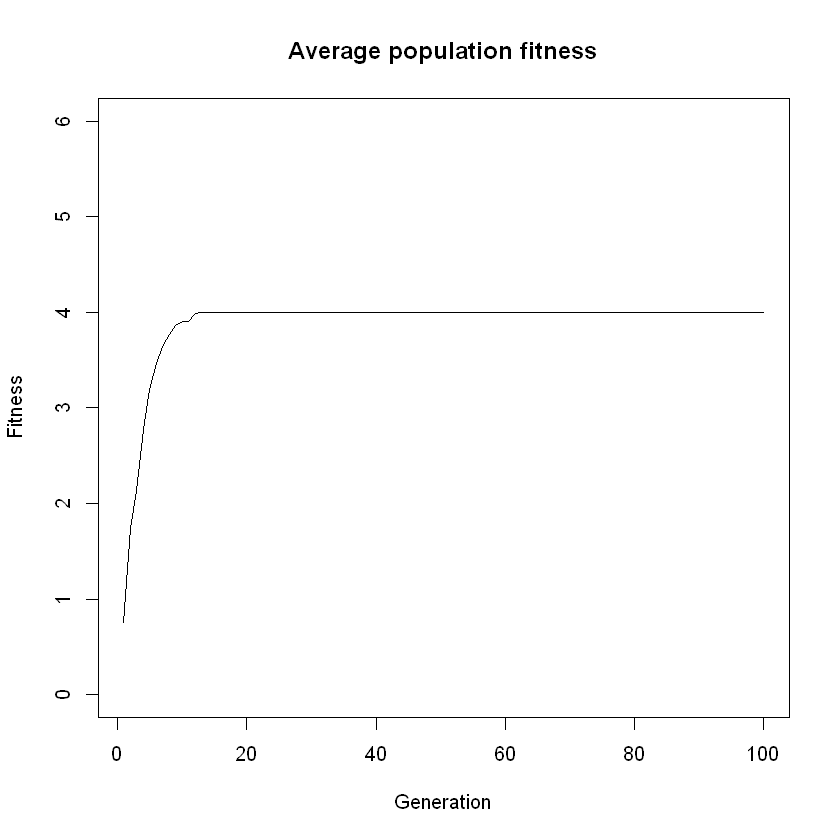

In [11]:
# parameters of the simulation
population_size	<- 100
genome_size <- 50
simulation_length	<- 100
mu <- 0

# Generate population and simulate evolution
population <- generate_population(population_size, genome_size)
population <- simulate_evolution(population)

- <font color="green"><b>Think:</b></font> You will notice the fitness stops increasing quite early in the simulation. Why is this?


> [ Your answer here ]

### 1.4 Evolution with mutation
In the previous simulation, we looked at selection _without_ mutation. Let’s now look at the case where every child’s nucleotide has a probability $\mu$ to change into a random other nucleotide.

#### **Exercise 6: Mu-tating genomes**
- <font color="green"><b>Think:</b></font> If $\mu = 0.01$, what is the chance that no changes occur in a genome? What is the chance that no changes occur in an entire population? And if $\mu = 0.001$ ?

> [ Your answer here ]

- <font color="orange"><b>Code:</b></font> In the first code cell below, copy-paste the code from the last code cell above, but change the mutation level to $\mu = 0.001$. Also adapt the length of the simulation to 1000 generations. Then run the cell to see the results.
- <font color="orange"><b>Code:</b></font> In the second code cell below, repeat the simulation again, but now with $\mu = 0.01$, and compare the two plots. This shows the mutation-selection balance.

In [12]:
### YOUR CODE HERE ###


In [13]:
### YOUR CODE HERE ###


- <font color="green"><b>Think:</b></font> In the simulation with relatively high mutation rate, why does the fitness stop increasing at a slightly lower level?

> [ Your answer here ]

## 2. Simulated evolution with ancestry
In the previous section we implemented computer simulations of evolution
in R. In this section, we extend this simulation, and think about the
patterns of genetic variation that the evolutionary process leaves in a
population. We look at methods for *phylogenetic tree reconstruction*.
These methods use the genetic variation in the most recent (current)
generation to reconstruct the evolutionary history of a population or a
set of species. 

We use a simple _clustering algorithm_ for
phylogenetic tree reconstruction. An algorithm is a description of a series of steps to do arrive at a certain end result or perform a calculation. In this case, the computer performs the steps for us.

The goal of this section is to learn about the possibilities and
difficulties that are involved in phylogenetic tree reconstruction.

### 2.1 Tracking ancestry
So far, we have simulated the evolution of strings of symbols, and looked at the effect of different fitness functions. Now we will repeat this simulation, but during the evolutionary process we will keep track of ancestry, so that we can reconstruct family trees of different individuals. We will start with a very simple simulation. 

The functions `generate_population` and `simulate_evolution_ancestry` in the code cell below allow us to run the same simulation as above, but now also generating a matrix `parent_matrix`. This matrix specifies the parent of each member in each generation (where the parent is the individual of the previous generation whose genetic material was inherited). 

In [14]:
# Function to generate new population
generate_population <-  function(population_size, genome_size) {
    # generate initial population with random strings
    population <- matrix(sample(c('A','G','C','U'), size=genome_size*population_size, replace=TRUE), population_size, genome_size)
    return(population)
}

# Function to simulate evolution with ancestry
simulate_evolution_ancestry <- function(population) {

    # initialise
    back_pointers = matrix(rep(0,population_size*(simulation_length-1)), simulation_length-1, population_size) 

    # compute fitness and population diversity
    fitness <- CAC_count(population)

    av_fitness <- rep(0, simulation_length)
    av_fitness[1] <- mean(fitness)

    diversity <- rep(0, simulation_length)
    diversity[1] <- compute_diversity(population)

    # simulate evolution
    for (j in 2:simulation_length) {

        # generate children. 
        indices_children <- sample(population_size, size=population_size, replace=TRUE, prob=fitness/sum(fitness))
        population_children <- population[indices_children,]
        back_pointers[j-1,] <- indices_children

        # mutation childrn
        population <- mutate_population_fast(population_children)

        # recompute fitness
        fitness <- CAC_count(population)

        # store current fitness and diversity
        av_fitness[j] <- mean(fitness)
        diversity[j] <- compute_diversity(population)
    }

    # plot average fitness and population diversity
    par(mfrow=c(1,2))
    ymax <- av_fitness[simulation_length]+2
    generation <- seq(1,simulation_length,1)
    plot(generation, av_fitness, type="l",ann=FALSE, ylim=c(0,ymax))
    title(main="Average population fitness", xlab="Generation", ylab="Fitness")
    plot(generation, diversity, type="l",ann=FALSE,ylim=c(0,population_size))
    title(main="Population diversity", xlab="Generation", ylab="Number of distinct phenotypes")

    results <- list(population=population,parent_matrix=back_pointers)
    par(mfrow=c(1,1))
    return(results)
}

With the code cell below, we can run the simulation with our desired settings. At the end of the simulation, we see a plot with the average population fitness and a plot with the diversity of the population over generations.

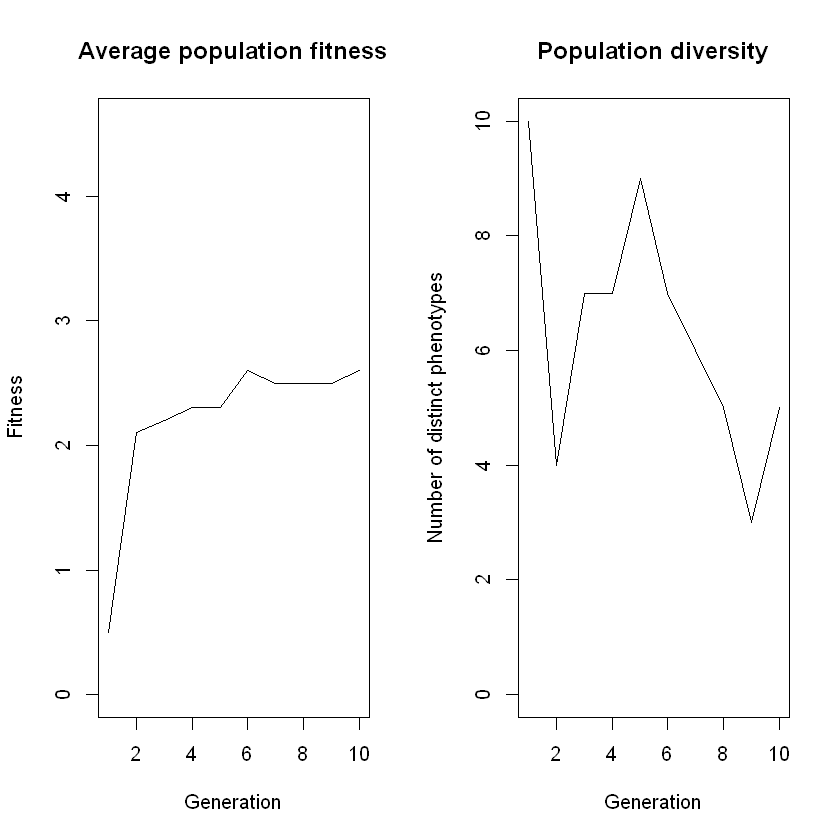

In [15]:
# parameters of simulation
population_size <- 10
genome_size <- 50
simulation_length	<- 10
mu <- 0.005

# Generate population and simulate evolution
population <- generate_population(population_size, genome_size)
results <- simulate_evolution_ancestry(population)
population <- results$population
parent_matrix <- results$parent_matrix

#### **Exercise 7: Finding the ancestors**
Visualise the parent matrix by running the code cell below:

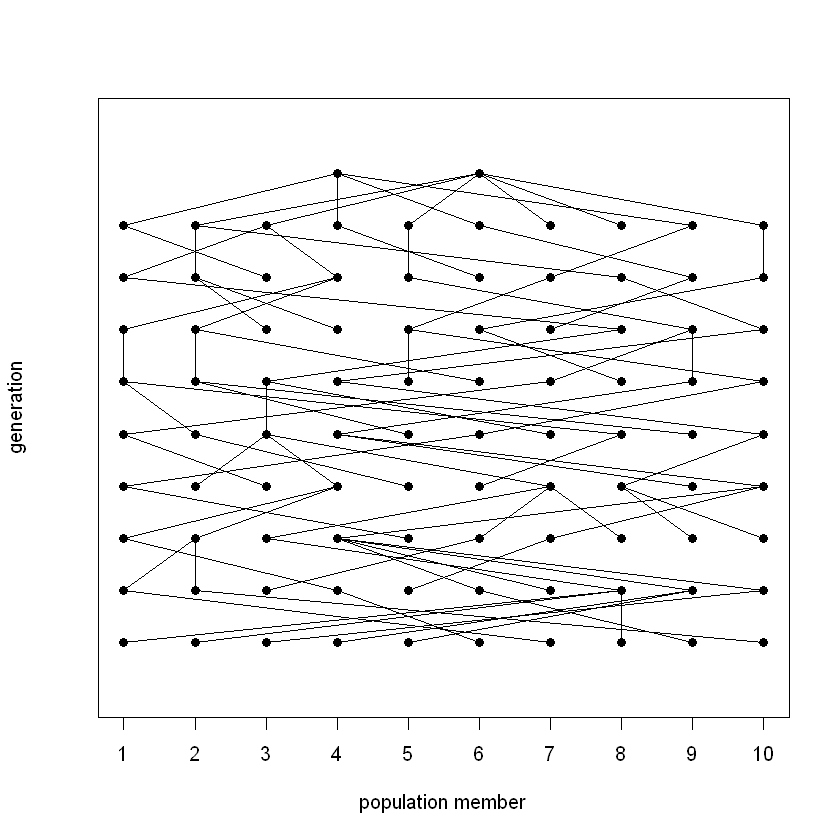

In [16]:
print_parent_matrix(parent_matrix)

- <font color="green"><b>Think:</b></font> Where in this plot can you find the first generation? 
- <font color="green"><b>Think:</b></font> Follow some paths up and down. Why do downward paths often end in dead ends, whereas upward paths always go all the way up?

> [ Your answers here ]

### 2.2 Plotting the family tree
Printing the parent matrix for large simulations (with big populations and many generations) is not very helpful, because the network is too dense to properly visualise (you may try if you want). 

Rather than looking the parent matrix, we will use the parent matrix to reconstruct a _family tree_ for only the last generation. That is, we only look at the members of previous generations whose offspring appears in the last generation. We will then generate a visual representation of the tree.

#### **Exercise 8: Ancestors in a tree**


- <font color="orange"><b>Code:</b></font> In the code cell below, copy-paste the code for running the simulation with ancestry (the one above exercise 7, which generates the two plots). Now, set the `population_size` parameter to 100 and the `simulation_length` parameter to 1000, and run the simulation.

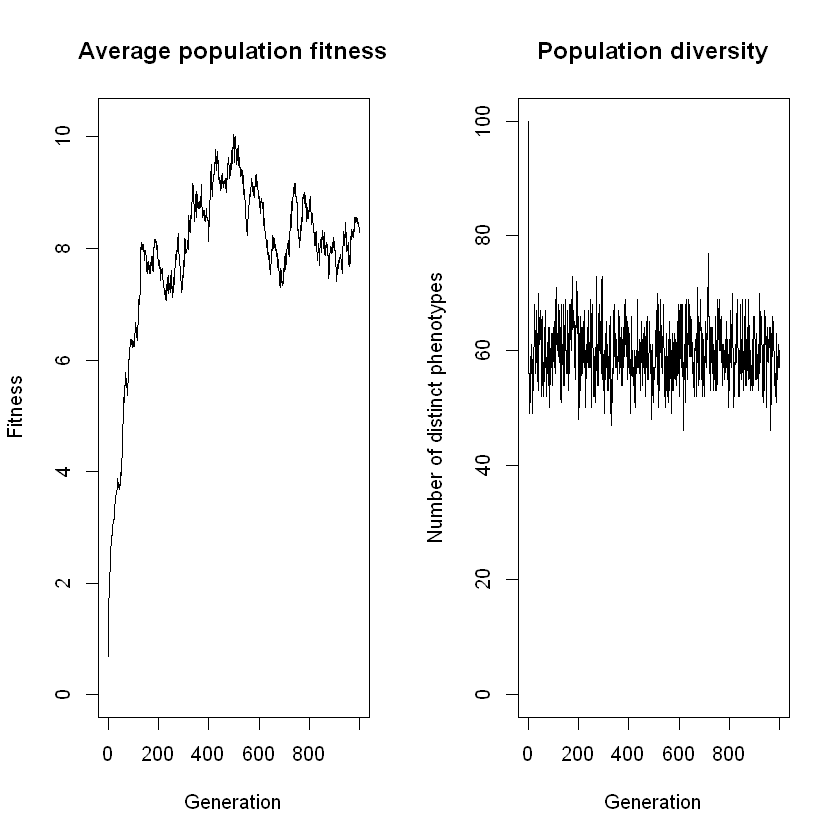

In [19]:
### YOUR CODE HERE ###


<font color="orange"><b>Code/Do:</b></font> Now, run the cell below to visualize the phylogenetic tree for the data you just generated.

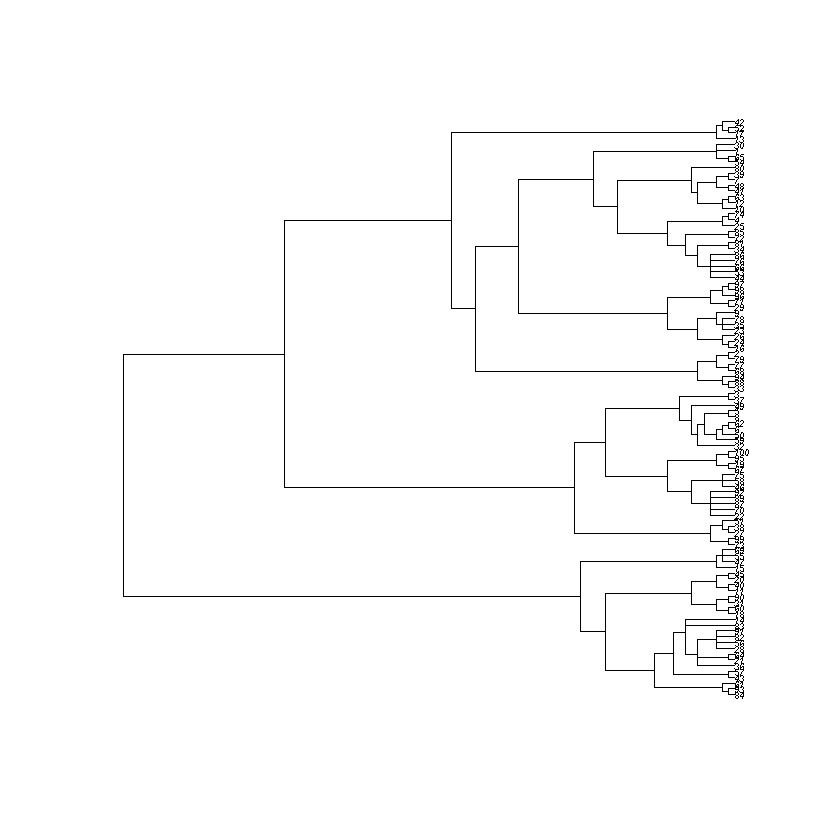

In [20]:
tree <- reconstruct_tree(parent_matrix)
plot_tree(tree)

Note: if the plot above is a bit hard to read, you can also generate a textual representation of the phylogenetic tree (this is called the 'Newick string') by running `print_tree(tree)` in the code cell below. From the result, copy everything between quotation marks (but exclude the two quotation marks themselves). Then, go to to [icytree.org](https://icytree.org/) and click _File > Enter tree directly..._ Paste the textual representation you’ve just copied and click _Done_. Save the generated tree (_File > Export tree as... > PNG image_), and insert the image in the cell below.

In [21]:
print_tree(tree)

[1] "(((((((84,93),(61)),((43,57),(((36),(21,64),(28,56,82,91)),(83),(14)))),(((18,60),(31,90)),((11,40),(20,45)))),((15),(47,55,69))),((((73,99),((27,38),(51))),((((22,70,87,89,92),((46),(58),(75))),(((67),(19)),(95,100))),((((32),(((59),((50),(6,62))),((8),(5)))),(49)),((37),(3))))),((((((33),(88)),(94)),((68,77),((79),(2)))),(((((16,24),(26)),((23,35,78),(9))),((29,71),((96),((98),(97))))),((((((44,53,66,76,86),(34,81)),((72),(85))),((25),(4,74))),((((10),(12,63)),((41,48),(7,39))),(80))),((54,65),(1),(30))))),((13),((17,52),(42)))))));"

> [ Your phylogenetic tree here ]

- <font color="green"><b>Think:</b></font> As far as you can judge, how many generations ago did the LCA of the current population live?
- <font color="green"><b>Think:</b></font> Which aspects of evolution leave traces that we can detect in the current generation, and which aspects do not?

> [ Your answers here ]

## 3. Phylogenetic reconstruction of biological data
In evolutionary research, the elaborate ancestry information represented by the parent matrix is usually not available. To reconstruct family trees we have to resort to different methods. Information about when species branched off (‘speciated’) can be deduced from genetic variation in the current population. For instance, horses are genetically more similar to donkeys than to, say, frogs. So, the last common ancestor of horses and frogs most likely lived much further in the past than the last common ancestor of horses and donkeys. In other words, the branch that would eventually evolve into frogs split off from the branch that would eventually evolve into horses earlier than the branch that would eventually evolve into donkeys. This type of analysis is called phylogenetic reconstruction. It’s based on genetic similarity between members of the current generation, which we measure using a _distance measure_.

The `phangorn` package (that we installed and loaded in the first code cell of this notebook) comes with a dataset that contains real genetic data (i.e., RNA samples) from many different species. 

Run the following code cell to load that dataset:

In [22]:
data(Laurasiatherian)

With the code cell below, you can print a summary of the data:

In [23]:
str(Laurasiatherian)

List of 47
 $ Platypus  : int [1:1605] 4 1 1 1 3 3 4 4 4 3 ...
 $ Wallaroo  : int [1:1605] 2 1 1 1 3 3 4 4 4 3 ...
 $ Possum    : int [1:1605] 2 1 1 1 3 3 4 4 4 3 ...
 $ Bandicoot : int [1:1605] 2 1 1 1 3 3 4 4 4 3 ...
 $ Opposum   : int [1:1605] 2 1 4 1 3 3 4 4 4 3 ...
 $ Armadillo : int [1:1605] 2 1 2 1 3 3 4 2 4 3 ...
 $ Elephant  : int [1:1605] 2 1 1 1 3 3 4 4 4 3 ...
 $ Aardvark  : int [1:1605] 4 1 1 1 3 3 4 4 4 3 ...
 $ Tenrec    : int [1:1605] 4 1 1 1 3 3 4 4 4 3 ...
 $ Hedghog   : int [1:1605] 1 4 1 1 3 3 4 2 4 3 ...
 $ Gymnure   : int [1:1605] 1 1 1 1 3 3 4 2 4 3 ...
 $ Mole      : int [1:1605] 1 1 1 1 3 3 4 4 4 3 ...
 $ Shrew     : int [1:1605] 4 1 1 1 3 3 4 4 4 3 ...
 $ Rbat      : int [1:1605] 2 1 4 1 3 3 2 4 4 2 ...
 $ FlyingFox : int [1:1605] 2 1 1 1 3 3 4 4 4 3 ...
 $ RyFlyFox  : int [1:1605] 4 1 1 1 3 3 4 4 4 3 ...
 $ FruitBat  : int [1:1605] 4 1 4 1 3 3 4 4 4 3 ...
 $ LongTBat  : int [1:1605] 2 1 4 1 3 3 4 4 4 3 ...
 $ Horse     : int [1:1605] 2 1 4 1 3 3 2 4 4 3 ...
 

The data originates from the (now closed) Allan Wilson Centre in New Zealand. To find out more about this data, have a look at [their website](http://www.allanwilsoncentre.ac.nz/massey/learning/departments/centres-research/allan-wilson-centre/our-research/resources/software-and-supplementary-materials.cfm).

We will try to reconstruct a phylogenetic tree for these species. That is, we will try to reconstruct when different species branched off from each other, based only on genetic information of the current population (the last generation). The first step is to measure ‘genetic distance’ between the genetic samples for each species. For simplicity, we assume that: 
1. all species ultimately originate from a single common ancestor (an uncontroversial assumption in evolutionary biology);
2. species have diverged genetically by picking up mutations at a roughly constant rate (a more problematic assumption). 

(Try and convince yourself that the phylogenetic tree reconstruction method we described requires the second assumption — and that this assumption is problematic when considering evolution in the real world.)

The distance between strings of DNA or RNA is typically measured by counting the number of mutations required to change one into the other. Because of the second assumption, the genetic distance between two species is proportional to the time that has passed since their last common ancestor.

#### **Exercise 9: Animal species distances**


<font color="orange"><b>Code/Do:</b></font> Select five species from the Laurasiatherian dataset (for instance three that you think are closely related and two that are more distantly related). Create a subset of the data containing just these five species, by changing the numbers in the code cell below:

In [24]:
mysubset <- subset(Laurasiatherian, subset=c(19,20,28,29,30))

The numbers correspond to the position of the species in the list printed by `str(Laurasiatherian)` above, i.e. Platypus = 1, Possum = 3, etc. ) You have to replace these numbers by the numbers corresponding to the species that you chose. Run the cell after you have done so. Then, verify that your subset contains the right species by running the following:

In [25]:
str(mysubset)

List of 5
 $ Horse     : int [1:1605] 2 1 4 1 3 3 2 4 4 3 ...
 $ Donkey    : int [1:1605] 2 1 4 1 3 3 2 4 4 3 ...
 $ FinWhale  : int [1:1605] 4 1 1 1 3 3 4 4 4 3 ...
 $ BlueWhale : int [1:1605] 4 1 1 1 3 3 4 4 4 3 ...
 $ SpermWhale: int [1:1605] 2 1 1 1 3 3 4 4 4 3 ...
 - attr(*, "class")= chr "phyDat"
 - attr(*, "weight")= int [1:1605] 1 5 1 444 3 314 1 1 328 1 ...
 - attr(*, "nr")= int 1605
 - attr(*, "nc")= num 4
 - attr(*, "index")= int [1:3179] 1 2 3 4 5 6 7 8 9 6 ...
 - attr(*, "levels")= chr [1:4] "a" "c" "g" "t"
 - attr(*, "allLevels")= chr [1:18] "a" "c" "g" "t" ...
 - attr(*, "type")= chr "DNA"
 - attr(*, "contrast")= num [1:18, 1:4] 1 0 0 0 0 1 1 1 0 0 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : NULL
  .. ..$ : chr [1:4] "a" "c" "g" "t"


Now, we compute the pairwise distance between all species in the subset using the function `dist.ml`. The results are stored in a _distance matrix_:

In [26]:
distance_matrix <- dist.ml(mysubset)
print(distance_matrix)

                Horse     Donkey   FinWhale  BlueWhale
Donkey     0.01814797                                 
FinWhale   0.11539023 0.11319215                      
BlueWhale  0.11392413 0.11173034 0.02657412           
SpermWhale 0.11502343 0.11796281 0.06811650 0.06777211


- <font color="green"><b>Think:</b></font> How can you read off the distance between two species from this matrix? Why are the numbers on the diagonal of this matrix zero?
- <font color="green"><b>Think:</b></font> Do the computed distances correspond to your intuitions about the selected species’ relatedness?

> [ Your answers here ]

#### **Exercise 10: Animal species phylogeny**
- <font color="green"><b>Think/Do:</b></font> Using pen and paper, or your favourite drawing software, reconstruct a phylogenetic tree that describes the evolutionary relations between your selected species. Use the principles described earlier. You shouldn’t need to do any calculations.

> [ Your hand-drawn phylogenetic tree here ]

## 4. Phylogenetic trees with hierarchical clustering

### 4.1 UPGMA
We can use a simple method called ‘hierarchical clustering’ to build the phylogenetic trees such as in the previous sections automatically. Hierarchical clustering can be done with the UPGMA algorithm. (If you need a refresher on how exactly it worked, look up the UPGMA chapter from the readings again!) In short, UPGMA follows these steps:

- Treat each datapoint (for example, a RNA sample of a species) as a separate “cluster” containing just one datapoint;
- Compute the distances between all clusters (using some distance measure; for example, genetic distance);
- Merge the two clusters that are nearest to each other into a new cluster;
- Repeat steps 2 and 3 until only all datapoints are in cluster.

### 4.2 Constructing a tree
To construct a phylogenetic tree, we can think of each merging of clusters as the joining of two branches. In the simplest version of this algorithm, we define ‘distance’ between a cluster A and a cluster B as the average distance between any datapoint in A and any datapoint in B — this is what UPGMA does. A slightly more complicated method, Ward’s clustering, uses the square root of the average of the squared point-to-point distances.

#### **Exercise 11: Animal species phylogeny, with UPGMA**
- <font color="green"><b>Think/Do:</b></font> Using the distances between species in `mysubset` (from the distance matrix you computed in the previous section), manually perform three cycles of the UPGMA algorithm with pen and paper.

> [ Your UPGMA steps here ]

#### **Exercise 12: Animal phylogenetic tree, from UPGMA**
Generate a phylogenetic tree for your subset and plot it using the code cell below:

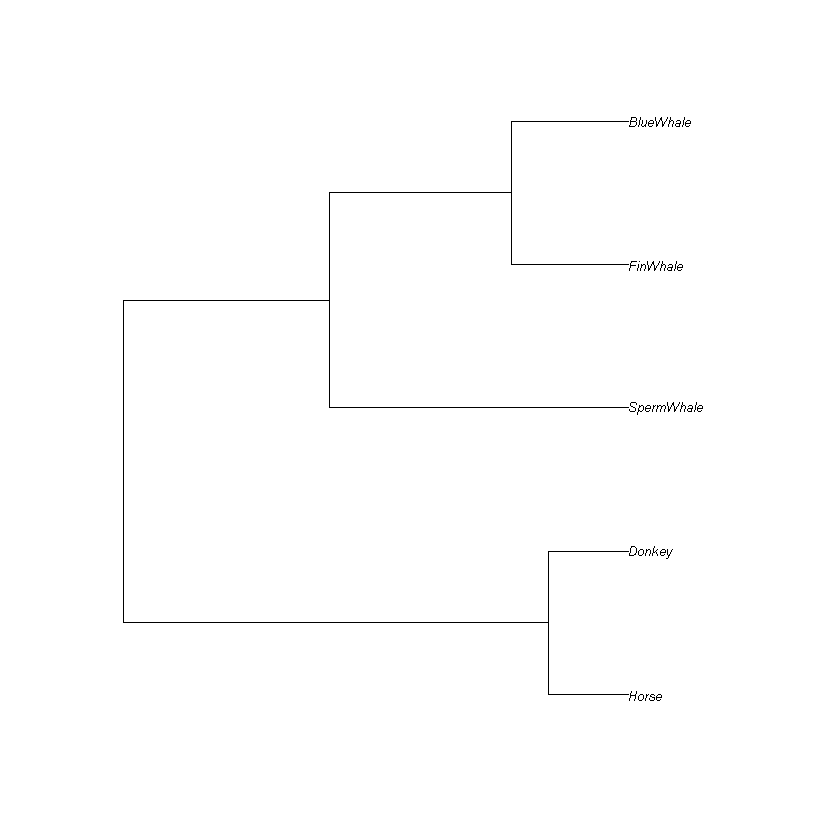

In [27]:
tree <- upgma(distance_matrix, method='average')
plot(tree, cex=0.65)

- <font color="green"><b>Think:</b></font> Is the tree the same as the one that you created before with pen and paper?
- <font color="orange"><b>Code:</b></font> In the code cell below, create a tree for the entire dataset. To do this, you first need to compute the distance matrix for the entire dataset, and then run the upgma algorithm on it. 
- <font color="green"><b>Think:</b></font> Does the generated tree agree with your expectations?

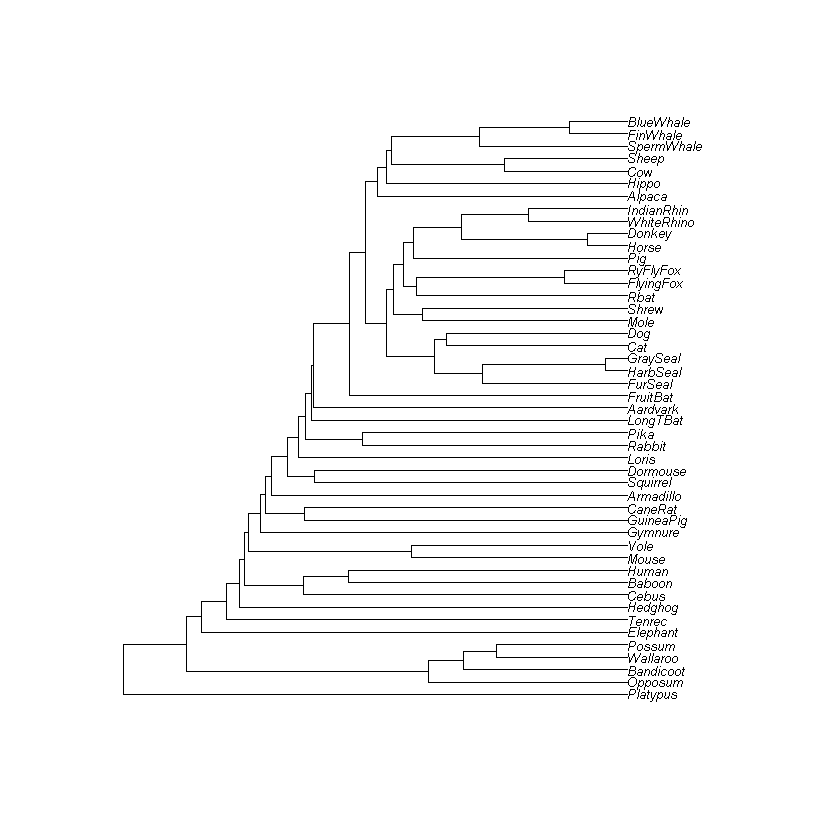

In [28]:
### YOUR CODE HERE ###


> [ Your answers here ]

_Optional:_ Try different methods for computing the distance between clusters by changing the parameter `method` from `'average'` to something else (options are, for instance, `'ward.D'`, `'single'` and `'median'`). Do you notice any changes in the resulting phylogenetic trees?

#### **Exercise 13: Our simulated ancestors in a tree, with UPGMA**
We will now investigate what happens if we perform phylogenetic analysis on the population resulting from our own simulated evolution. Remember that, since this is a simulation over which we have full control, we can reconstructed the actual phylogenetic tree using the information that we stored in the parent matrix.

Generate a distance matrix between the members of the last generation from your simulation, and reconstruct a phylogenetic tree with the `upgma` function (choose your preferred _method_, e.g. `ward.D`):

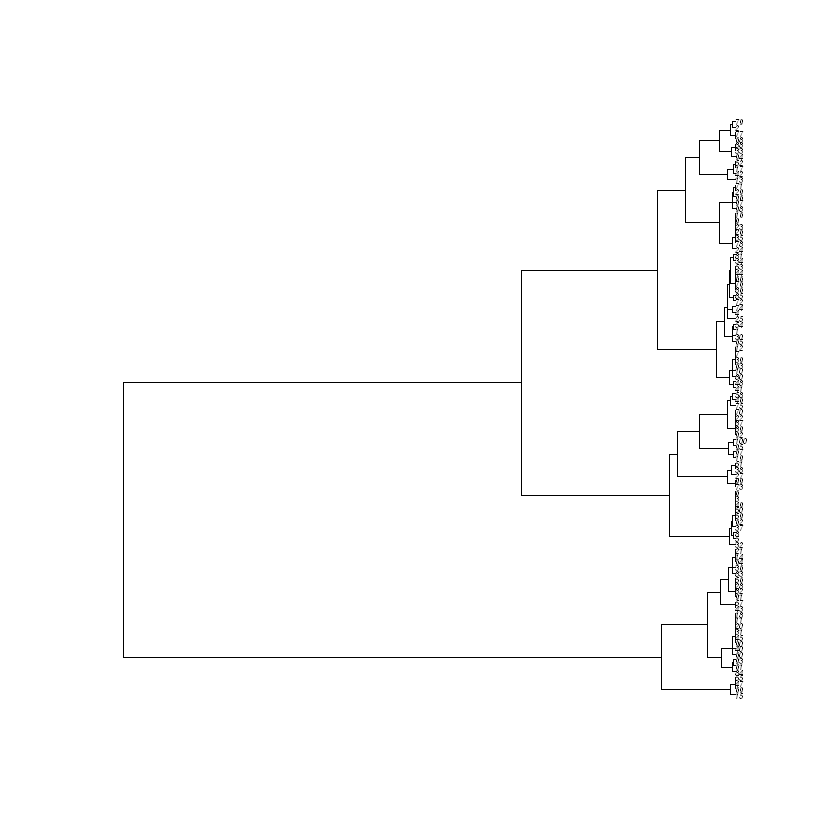

In [29]:
distance_matrix <- compute_distance_matrix(population)
tree <- upgma(distance_matrix, method='ward.D')
plot(tree, cex=0.4)

If the tree above is a bit hard to read again, use the cell below to print the Newick string that you can paste into [icytree.org](https://icytree.org/):

In [30]:
write.tree(tree)

[1] "(((15:0.03,(69:0,(47:0,55:0):0):0.03):0.5004195804,(((84:0.01666666667,(61:0.01,93:0.01):0.006666666667):0.08166666667,(60:0.01785714286,(40:0.01714285714,(90:0,(45:0,(31:0,(20:0,(11:0,18:0):0):0):0):0):0.01714285714):0.0007142857143):0.08047619048):0.1034848485,((43:0,57:0):0.1054545455,((91:0,(82:0,(28:0,56:0):0):0):0.048,(83:0.017,(36:0.015,(64:0,(14:0,21:0):0):0.015):0.002):0.031):0.05745454545):0.09636363636):0.3286013986):3.889839463,(((32:0.03688888889,((5:0.01,8:0.01):0.01396825397,(37:0.01714285714,(62:0,(59:0,(50:0,(49:0,(3:0,6:0):0):0):0):0):0.01714285714):0.006825396825):0.01292063492):0.4344139434,(((73:0,99:0):0.05333333333,(27:0.02666666667,(38:0,51:0):0.02666666667):0.02666666667):0.3608823529,(((19:0.01,67:0.01):0.04,(95:0.01,100:0.01):0.04):0.2041666667,((92:0,(89:0,(87:0,(22:0,70:0):0):0):0):0.05416666667,(75:0.03333333333,(46:0.02,58:0.02):0.01333333333):0.02083333333):0.2):0.1600490196):0.05708714597):1.075564887,((((41:0.01,48:0.01):0.02916666667,(80:0.01733333333,(10:0.016,(63:0,(39:0,(7:0,12:0):0):0):0.016):0.001333333333):0.02183333333):0.09541666667,((65:0.01833333333,(30:0.01666666667,(1:0.01,54:0.01):0.006666666667):0.001666666667):0.06125,(25:0.05575757576,((4:0.02,74:0.02):0.03313131313,((72:0.01,85:0.01):0.03206349206,((86:0,(76:0,(66:0,(44:0,53:0):0):0):0):0.03571428571,(34:0.01,81:0.01):0.02571428571):0.006349206349):0.01106782107):0.002626262626):0.02382575758):0.055):0.4232442954,(((24:0.01714285714,(78:0,(35:0,(26:0,(23:0,(9:0,16:0):0):0):0):0):0.01714285714):0.09604761905,(98:0.018,(97:0.01666666667,(96:0.01333333333,(29:0,71:0):0.01333333333):0.003333333333):0.001333333333):0.09519047619):0.2461837004,((13:0.05166666667,(42:0.01333333333,(17:0,52:0):0.01333333333):0.03833333333):0.2074891775,((94:0.02666666667,(33:0,88:0):0.02666666667):0.08523809524,((68:0,77:0):0.03,(2:0.02,79:0.02):0.01):0.0819047619):0.1472510823):0.1002183324):0.1984534522):0.98904009):2.873391325);"

Now generate the _actual_ family tree of the simulation by running the cell below:

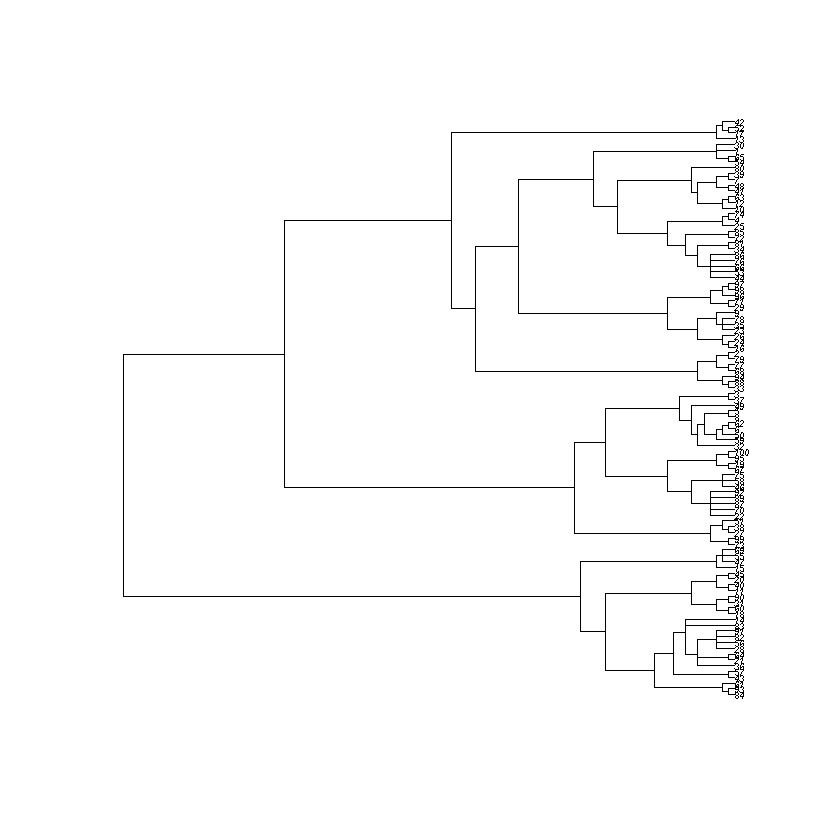

In [31]:
gold_standard_tree <- reconstruct_tree(parent_matrix)
plot_tree(gold_standard_tree)

Newick string for pasting into [icytree.org](https://icytree.org/):

In [32]:
print_tree(gold_standard_tree)

[1] "(((((((84,93),(61)),((43,57),(((36),(21,64),(28,56,82,91)),(83),(14)))),(((18,60),(31,90)),((11,40),(20,45)))),((15),(47,55,69))),((((73,99),((27,38),(51))),((((22,70,87,89,92),((46),(58),(75))),(((67),(19)),(95,100))),((((32),(((59),((50),(6,62))),((8),(5)))),(49)),((37),(3))))),((((((33),(88)),(94)),((68,77),((79),(2)))),(((((16,24),(26)),((23,35,78),(9))),((29,71),((96),((98),(97))))),((((((44,53,66,76,86),(34,81)),((72),(85))),((25),(4,74))),((((10),(12,63)),((41,48),(7,39))),(80))),((54,65),(1),(30))))),((13),((17,52),(42)))))));"

- <font color="green"><b>Think:</b></font> How well does the reconstruction produced by the hierarchical clustering algorithm match the actual family tree?
- <font color="green"><b>Think:</b></font> How can you explain the differences between the reconstructed and the actual family tree?

## 5. Phylogenetic reconstruction of languages
In the tutorial you have learned about features of language and music used in comparative research, and about variation across languages and musics. By studying some specific examples, you have seen that both languages and musical traditions are transmitted culturally, and are subject to a process of cultural evolution. In this final section of the computer lab, you will use the methods that we saw for phylogenetic tree reconstruction in the previous sections to reconstruct the cultural evolutionary history of languages.

#### **Exercise 14: Languages in a tree, with UPGMA**

We preprocessed a dataset for you so it can be loaded into R. To do this, run the following code cell:

In [15]:
load("data/language_data.Rdata")

This will create an object called `mydata` containing the dataset. You can check the languages in the data as follows:

In [42]:
names(mydata)

[1] "Hittite"             "Luvian"              "Lycian"             
  [4] "Tocharian_A"         "Tocharian_B"         "Albanian_C"         
  [7] "Albanian_K"          "Albanian_G"          "Albanian_Top"       
 [10] "Classical_Armenian"  "Armenian_List"       "Armenian_Mod"       
 [13] "Ancient_Greek"       "Avestan"             "Old_Persian"        
 [16] "Persian_List"        "Afghan"              "Wakhi"              
 [19] "Baluchi"             "Waziri"              "Tadzik"             
 [22] "Kurdish"             "Iron_Ossetic"        "Digor_Ossetic"      
 [25] "Greek_Mod"           "Greek_ML"            "Vedic_Sanskrit"     
 [28] "Nepali_List"         "Assamese"            "Oriya"              
 [31] "Bengali"             "Bihari"              "Marwari"            
 [34] "Hindi"               "Urdu"                "Sindhi"             
 [37] "Lahnda"              "Gujarati"            "Marathi"            
 [40] "Kashmiri"            "Singhalese"          "Romani"             
 [43] "Serbocroatian"       "Bulgarian"           "Macedonian"         
 [46] "Russian"             "Polish"              "Byelorussian"       
 [49] "Ukrainian"           "Czech_E"             "Slovak"             
 [52] "Czech"               "Lusatian_U"          "Lusatian_L"         
 [55] "Slovenian"           "Old_Church_Slavonic" "Old_Prussian"       
 [58] "Latvian"             "Lithuanian_ST"       "Faroese"            
 [61] "Icelandic_ST"        "Riksmal"             "Danish"             
 [64] "Swedish_List"        "Swedish_VL"          "Swedish_Up"         
 [67] "Old_Norse"           "Old_High_German"     "Old_English"        
 [70] "English_ST"          "Frisian"             "Flemish"            
 [73] "Dutch_List"          "Luxembourgish"       "German_ST"          
 [76] "Gothic"              "Catalan"             "Portuguese_ST"      
 [79] "Spanish"             "Sardinian_C"         "Sardinian_L"        
 [82] "Sardinian_N"         "Walloon"             "French"             
 [85] "Provencal"           "Ladin"               "Romansh"            
 [88] "Friulian"            "Italian"             "Romanian_List"      
 [91] "Vlach"               "Latin"               "Oscan"              
 [94] "Umbrian"             "Old_Irish"           "Cornish"            
 [97] "Breton_ST"           "Breton_SE"           "Breton_List"        
[100] "Welsh_C"             "Welsh_N"             "Irish_A"            
[103] "Scots_Gaelic"

- <font color="orange"><b>Code/Do:</b></font> Choose a subset of the list of languages. We will initially build a phylogenetic tree of this subset. Define your subset with the subset function. For instance, if you want to select languages 13, 14, 15, 63 and 71 you type:

In [43]:
mysubset <- subset(mydata, c(13:15,63,71))

Create a distance matrix of your subset, by letting the computer count the number of feature values that differ between two languages (“hamming distance”):

In [44]:
distance_matrix <- dist.hamming(mysubset)

Pick your favourite clustering algorithm and method and generate a tree:

In [45]:
tree <- upgma(distance_matrix, method='ward.D')

Plot your tree:

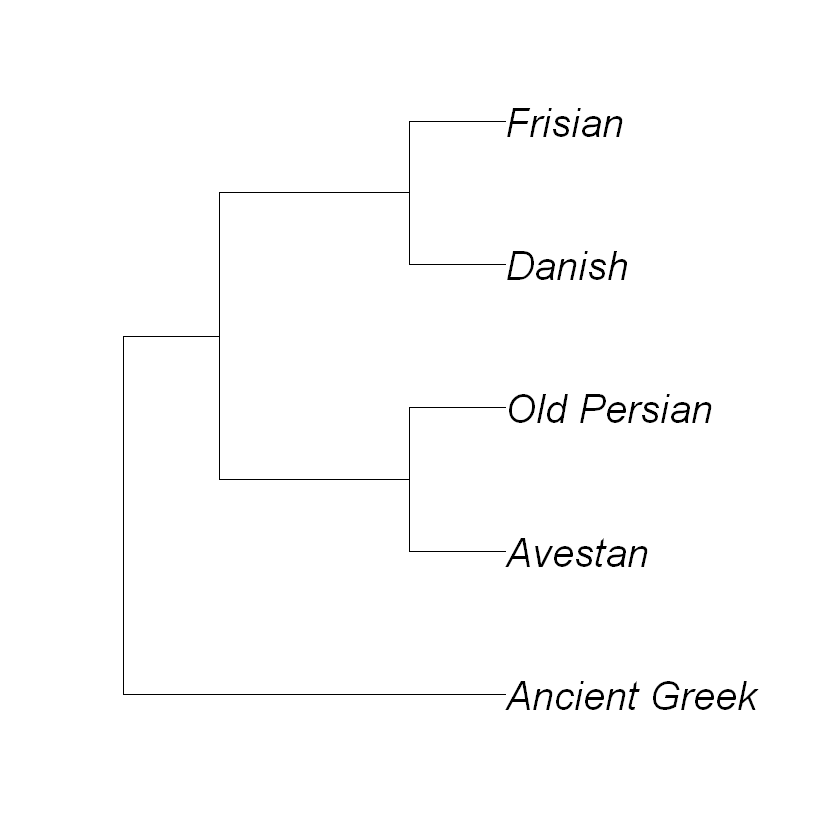

In [46]:
plot(tree, use.edge.length=FALSE, cex=2)

- <font color="orange"><b>Code:</b></font> In the code cell below, do the same thing for the entire dataset (i.e. compute the distance matrix, run UPGMA, plot the tree). You might want to adapt the `cex` parameter in the plot function, that sets the font size. Be aware of the influence the clustering algorithm and method for computing the distances between clusters can have.

In [47]:
### YOUR CODE HERE ###


After generating the tree above, you can use the following again to get the Newick string to paste into [icytree.org](https://icytree.org/):

In [ ]:
write.tree(tree)

- <font color="green"><b>Think:</b></font> What are the nine main language families you can distinguish within the Indo-European family, and in which regions of the world are they spoken (before colonial times)?

> [ Your answer here ]